# Deep Music Genre

In [2]:
import itertools
import os
import _pickle as pickle

import IPython
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from keras import optimizers
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split

from models import resnet, spotify

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Visualizing and preprocessing

We already have the preprocessed songs as melspectograms (see scripts/generate_data.py). Let's load them and see one for each genre.

In [15]:
GTZAN_ROOT = 'datasets/genres'
GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
CLASSES = len(GTZAN_GENRES)

In [16]:
with open(os.path.join(GTZAN_ROOT, 'data.pickle'), 'rb') as f:
    X, y = pickle.load(f)
    
print(X.shape)
print(y.shape)

(1000, 647, 128)
(1000, 10)


In [23]:
def plot_spectogram(x, tag=None):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(x.T, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    if tag:
        plt.title('Melspectogram for ' + genre + ' 0')
        plt.tight_layout()

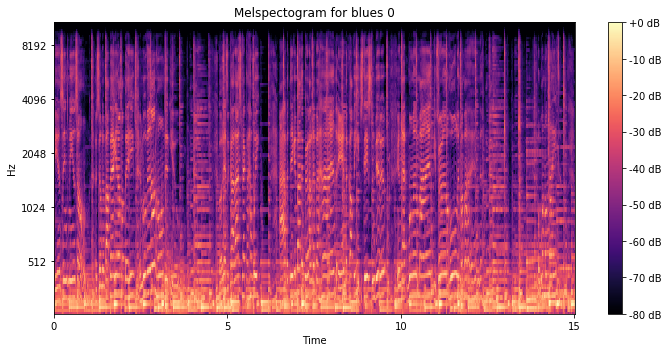

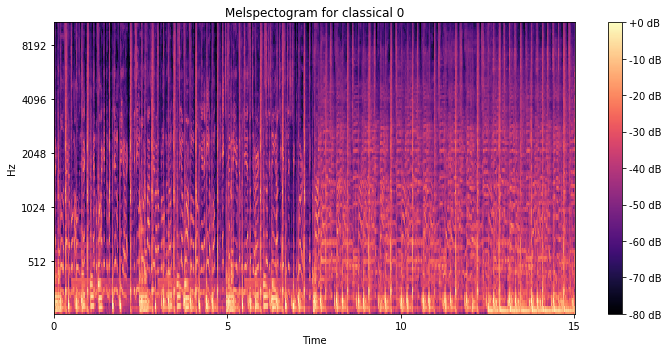

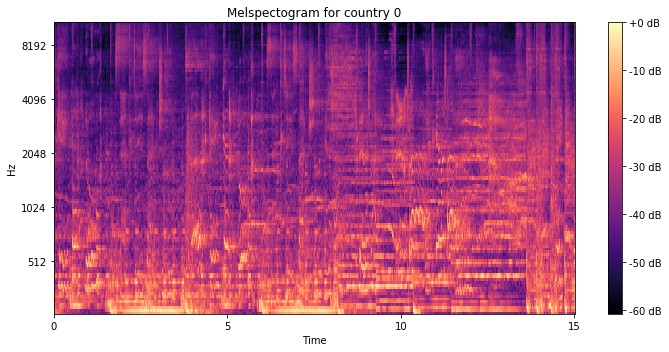

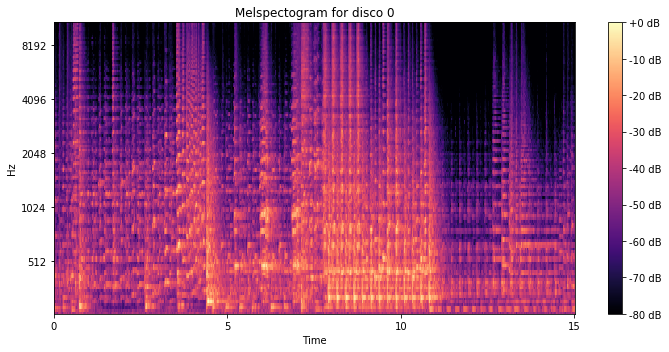

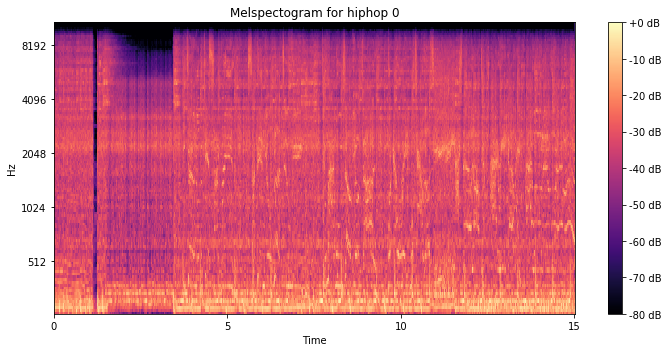

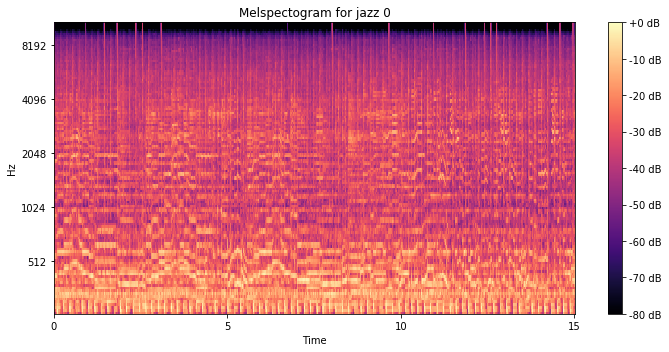

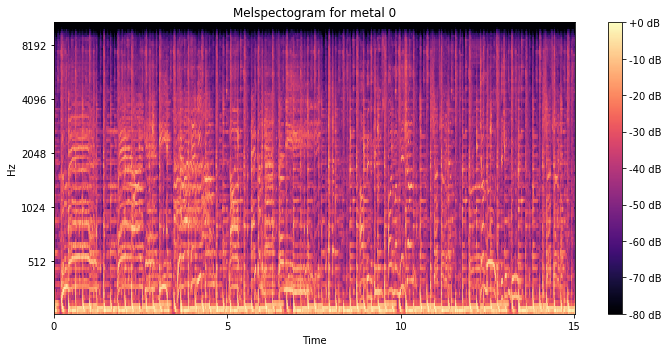

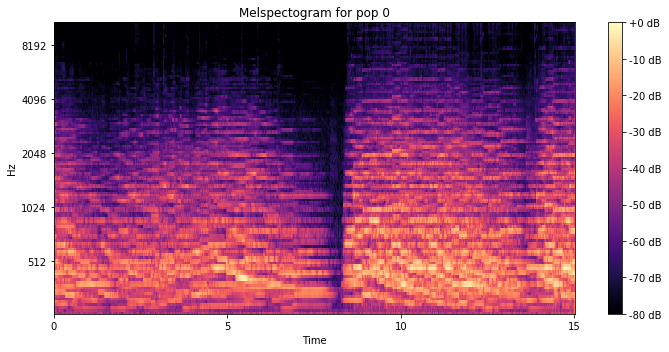

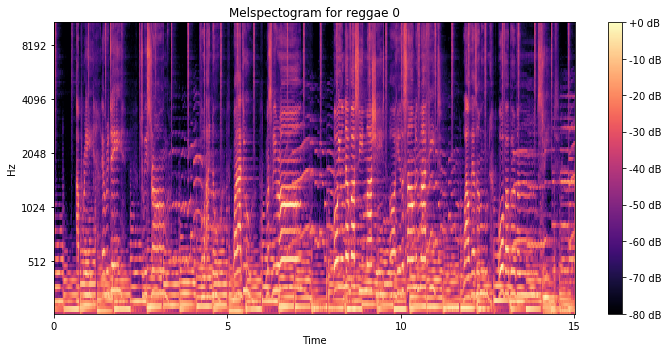

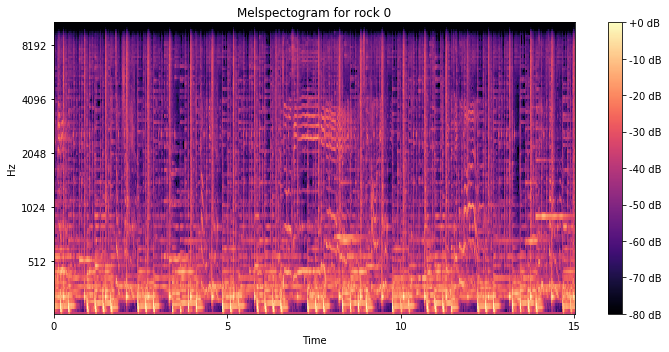

In [18]:
for i, genre in enumerate(GTZAN_GENRES):
    plot_spectogram(X[i*100, :, :], tag=genre)

Let's split the data into validation, test and train sets. Then we'll also shuffle it.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.33, random_state=42)

print('TRAIN: X = {0}, y = {1}'.format(X_train.shape, y_train.shape))
print('TEST: X = {0}, y = {1}'.format(y_val.shape, y_val.shape))

TRAIN: X = (670, 647, 128), y = (670, 10)
TEST: X = (330, 10), y = (330, 10)


Now let's center the data around the mean, and split it into test, train and validation sets.

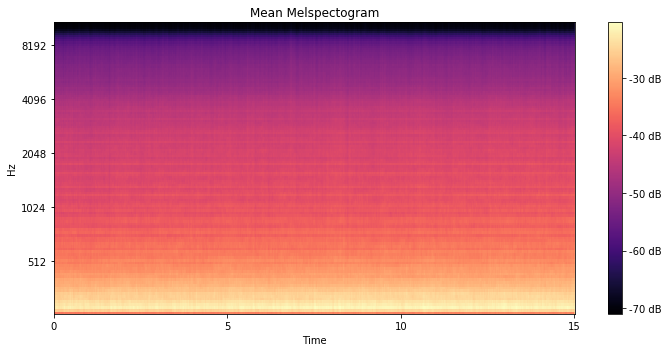

In [6]:
mean_spectogram = np.mean(X_train, axis=0)
plt.figure(figsize=(10, 5))
librosa.display.specshow(mean_spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mean Melspectogram')
plt.tight_layout()

In [7]:
std_spectogram = np.std(X_train, axis=0)
X_val = (X_val - mean_spectogram) / std_spectogram
X_train = (X_train - mean_spectogram) / std_spectogram

## Training the model

We'll be using a Resnet model with 5 Identity residual units per residual block (as described in [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)).

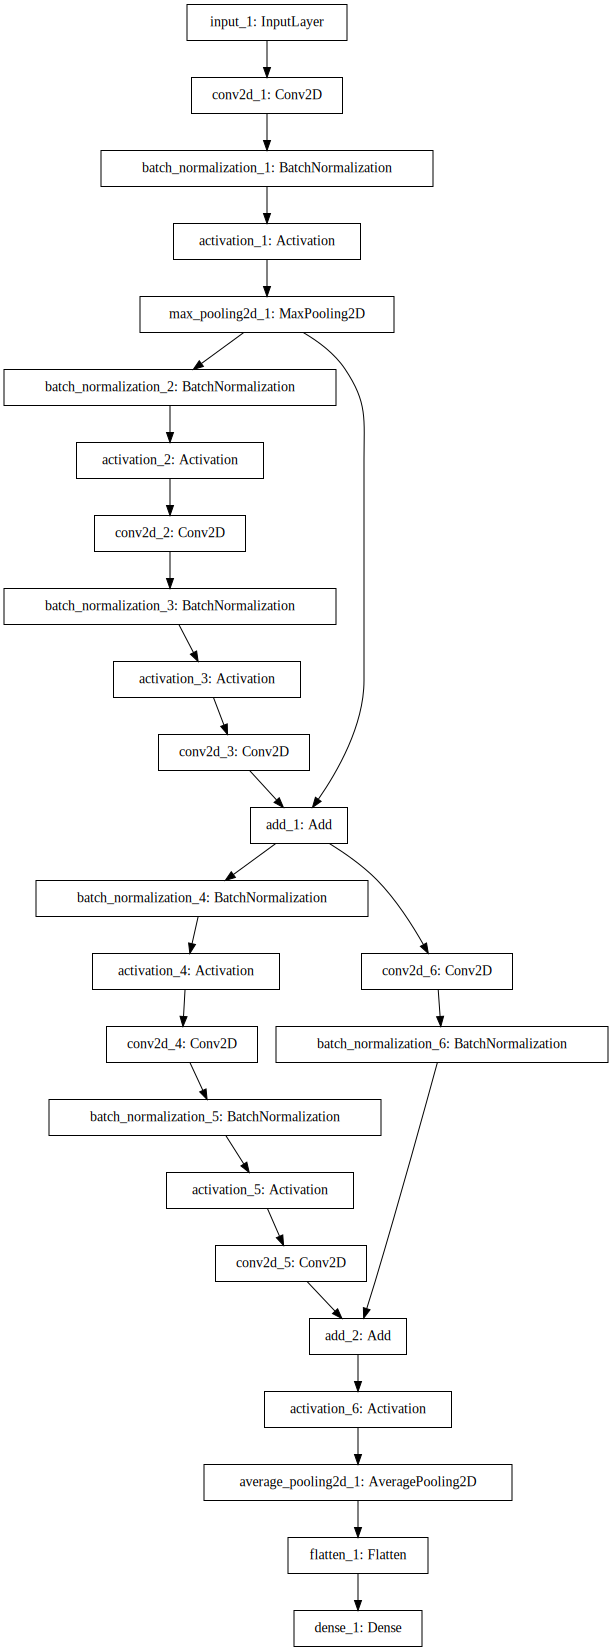

In [ ]:
X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))
model = resnet.get(X_train[0].shape, CLASSES, resnet.IdentityResidualUnit, [1,1])
#model = spotify.get(X_train[0].shape, CLASSES)
IPython.display.SVG(model_to_dot(model).create(prog='dot', format='svg'))

Now let's train our model using Adam.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

optimizer = optimizers.Adam(lr=0.001, decay=0.0001)
with tf.device('/gpu:0'):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        verbose=1)

Train on 670 samples, validate on 330 samples
Epoch 1/100
670/670 [==============================] - 130s - loss: 13.5450 - acc: 0.0970 - val_loss: 9.1285 - val_acc: 0.1545
Epoch 2/100
670/670 [==============================] - 129s - loss: 6.6978 - acc: 0.1522 - val_loss: 2.3024 - val_acc: 0.0909
Epoch 3/100
670/670 [==============================] - 129s - loss: 2.0945 - acc: 0.2507 - val_loss: 2.1287 - val_acc: 0.1939
Epoch 4/100
670/670 [==============================] - 129s - loss: 1.8002 - acc: 0.3403 - val_loss: 1.9505 - val_acc: 0.3303
Epoch 5/100
670/670 [==============================] - 128s - loss: 1.4765 - acc: 0.4866 - val_loss: 2.3850 - val_acc: 0.2606
Epoch 6/100
670/670 [==============================] - 129s - loss: 1.3801 - acc: 0.5493 - val_loss: 2.5711 - val_acc: 0.1909
Epoch 7/100
670/670 [==============================] - 128s - loss: 1.1905 - acc: 0.5716 - val_loss: 4.7831 - val_acc: 0.2333
Epoch 8/100
670/670 [==============================] - 129s - loss: 1.1

In [ ]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_complete = np.vstack([X_train, X_val])
y_complete = np.argmax(np.vstack([y_train, y_val]), axis=1)
y_pred = np.argmax(model.predict(X_complete), axis=1)

cm = sklearn.metrics.confusion_matrix(y_complete, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Class predictions')
plt.colorbar()
tick_marks = np.arange(CLASSES)
plt.xticks(tick_marks, GTZAN_GENRES, rotation=45)
plt.yticks(tick_marks, GTZAN_GENRES)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Magnatagatune

INFO:tensorflow:Restoring parameters from datasets/magnatagatune/data.ckpt


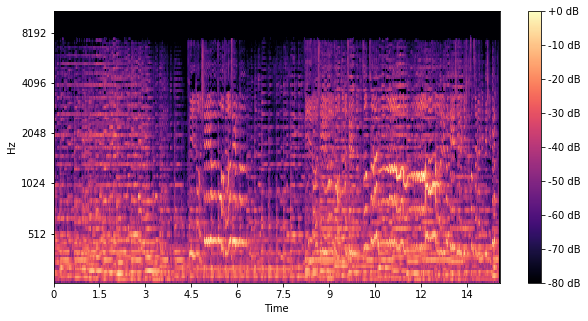

In [24]:
PATH_MAGNATAGATUNE = 'datasets/magnatagatune'
X_DATA_SHAPE = (15659, 628, 128)
Y_DATA_SHAPE = (15659, 40)

with tf.Graph().as_default():
    X_init = tf.placeholder(tf.float32, shape=X_DATA_SHAPE)
    y_init = tf.placeholder(tf.float32, shape=Y_DATA_SHAPE)
    X = tf.Variable(X_init, name='X_data')
    y = tf.Variable(y_init, name='y_data')
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, os.path.join(PATH_MAGNATAGATUNE, 'data.ckpt'))
        plot_spectogram(X[0].eval())

In [12]:
with tf.Graph().as_default():
    X_init = tf.placeholder(tf.float32, shape=(3, 4))
    y_init = tf.placeholder(tf.float32, shape=(3, 3))
    X = tf.Variable(X_init, name='X_data')
    y = tf.Variable(y_init, name='y_data')
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer(), feed_dict={
            X_init: [[2, 3, 4, 5], [5, 6, 7, 8], [8, 9, 0, 1]],
            y_init: [[1, 0, 0], [0, 1, 0], [0, 0, 1]]})
        indices = [0, 2]
        print(X[0][indices].eval())

ValueError: Index out of range using input dim 1; input has only 1 dims for 'strided_slice_1' (op: 'StridedSlice') with input shapes: [4], [2], [2], [2] and with computed input tensors: input[3] = <1 1>.